# LSTM Model : XOM(Partial)

####  Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import style
from tensorflow.keras.models import Sequential #Build the model layer by layer
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
style.use("fivethirtyeight")

# 1. Importing dataset

In [2]:
XOM_partial_ds=pd.read_csv('dataset/XOM.csv')

### 1.1 Date Extration Within 2018-07-12 - 2022-07-12

In [3]:
mask=(XOM_partial_ds['Date'] >= '2018-07-12') & (XOM_partial_ds['Date'] <= '2022-07-12')
XOM_partial_ds=XOM_partial_ds.loc[mask]
print(XOM_partial_ds)

             Date       Open       High        Low      Close    Volume  \
14229  2018-07-12  66.294395  66.478077  65.735350  66.038834   9762200   
14230  2018-07-13  66.030853  66.885389  65.935015  66.533989   8720000   
14231  2018-07-16  65.903063  66.118696  65.487777  65.879105   8306900   
14232  2018-07-17  65.695424  66.086751  65.519724  65.735352   7373300   
14233  2018-07-18  65.328066  65.743352  65.080487  65.663490   8711900   
...           ...        ...        ...        ...        ...       ...   
15231  2022-07-06  83.760002  85.230003  81.010002  83.279999  33375700   
15232  2022-07-07  85.379997  86.760002  85.300003  85.940002  23817400   
15233  2022-07-08  86.949997  87.300003  84.930000  86.080002  17668000   
15234  2022-07-11  85.169998  86.120003  84.360001  85.639999  15603800   
15235  2022-07-12  83.779999  85.050003  82.860001  84.500000  21009100   

       Dividends  Stock Splits  
14229        0.0           0.0  
14230        0.0           0.0  


### 1.2 Create Average column

In [4]:
average=(XOM_partial_ds['Open']+XOM_partial_ds['High']+XOM_partial_ds['Low']+XOM_partial_ds['Close'])/4
y=average.values
XOM_partial_ds.insert(8, "Average", average, True)

### 1.3 Drop OHLC column

In [5]:
#Drop columns - Date,Volume,Dividends,Stock Splits 
df=XOM_partial_ds.drop(['Open', 'High', 'Low', 'Close','Dividends','Stock Splits','Volume'], axis=1)
XOM_partial_ds_Ori=df
XOM_partial_ds1=df

In [6]:
df

,Date,Average
14229,2018-07-12,66.136664
14230,2018-07-13,66.346312
14231,2018-07-16,65.847160
14232,2018-07-17,65.759313
14233,2018-07-18,65.453849
...,...,...
15231,2022-07-06,83.320002
15232,2022-07-07,85.845001
15233,2022-07-08,86.315001
15234,2022-07-11,85.322500


In [8]:
#Pick up only 'Average' column
XOM_partial_ds1=df.reset_index()['Average'] 

### 1.4 Dateset Size

In [8]:
XOM_partial_ds1.shape 

(1007, 2)

# 2. Data Preprocessing

To build a (LSTM) model, we need to separate our stock prices data into a training set and a test set. Besides, we will also normalize our data so that all the values are in the same scale.

### 2.1 MinMaxScaler 

Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

In [9]:
#LSTM are sensitive to the scale of the data , we use MinMaxScaler to scale the data range to 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
XOM_partial_ds1=scaler.fit_transform(np.array(XOM_partial_ds1).reshape(-1,1)) #Fit to data, then transform it

ValueError: could not convert string to float: '2018-07-12'

#### Exclude 30 days data 

In [10]:
XOM_partial_ds1_Future=XOM_partial_ds1[-30:]
XOM_partial_ds1=XOM_partial_ds1[:-30] #Exclude 30 days

In [11]:
#df1 have already converted to array and have the values between 0 to 1
XOM_partial_ds1

,Date,Average
14229,2018-07-12,66.136664
14230,2018-07-13,66.346312
14231,2018-07-16,65.847160
14232,2018-07-17,65.759313
14233,2018-07-18,65.453849
...,...,...
15201,2022-05-20,91.945000
15202,2022-05-23,93.467501
15203,2022-05-24,93.582500
15204,2022-05-25,95.470001


In [12]:
len(XOM_partial_ds1)

977

### 2.2 Preparation of Training and Testing set

- We cannot use Cross Validation or Random Seed to split train and test because stock price always depent on previous date.
- Here we will only need the average prices from our dataset to train our (LSTM) model. We are going to extract 80% of the average prices from our acquired stock data as our training set.

In [14]:
training_size=int(len(XOM_partial_ds1)*0.8) #Split train into 80%
test_size=len(XOM_partial_ds1)-training_size 
train_data,test_data=XOM_partial_ds1.iloc[0:training_size,:],XOM_partial_ds1.iloc[training_size:len(XOM_partial_ds1),:1]

In [16]:
test_data.shape

(196, 1)

#### Training and Testing size 

In [15]:
training_size,test_size

(781, 196)

In [16]:
#Convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1): #timestep default is 1,more better timestep
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0] #i=0 to 99(X_train) 100..(y_train)
        print(len(a))
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
        print(f'({i})')
        print(f'DataX \n----------------\n {a}\n')
        print(f'DataY \n----------------\n {dataset[i+time_step,0]}\n')
        print('========================================================')
    return np.array(dataX),np.array(dataY) #Return as array

In [17]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#Converting independent and dependent feature based on time steps
time_step=100 #Predict based on 100 days
X_train,y_train=create_dataset(train_data,time_step)
X_test,ytest=create_dataset(test_data,time_step)

100
(0)
DataX 
----------------
 [0.50426883 0.50700231 0.50049417 0.49934877 0.49536601 0.49724037
 0.4913828  0.49198153 0.49848998 0.50843411 0.51621775 0.49081024
 0.49245027 0.49252846 0.48130855 0.47370721 0.47524295 0.47654469
 0.4856037  0.48365155 0.48037136 0.47650002 0.47355442 0.4689781
 0.45498617 0.45879963 0.46487508 0.46842579 0.47339648 0.47868284
 0.47613194 0.47991911 0.48525827 0.48851955 0.48999233 0.48846699
 0.48525839 0.48673124 0.48959782 0.49291162 0.49338519 0.50553593
 0.50892885 0.51784476 0.51179558 0.5118746  0.51779238 0.5233154
 0.52744442 0.53501911 0.53651844 0.54985262 0.55527074 0.54667028
 0.54624942 0.5393062  0.5426202  0.54814309 0.55072074 0.54251491
 0.53954304 0.54112072 0.55066802 0.5429356  0.51219005 0.49940807
 0.49609412 0.49143883 0.49488414 0.501249   0.50356347 0.49927639
 0.48115542 0.47189759 0.46671623 0.45929936 0.45666947 0.46477
 0.47902505 0.48502162 0.50038093 0.50579916 0.50245893 0.50998102
 0.51021746 0.49800465 0.49994411 


DataY 
----------------
 0.46383062151871424

100
(108)
DataX 
----------------
 [0.45028964 0.43466809 0.41535371 0.40390305 0.3790096  0.3706941
 0.34691624 0.35430189 0.36378654 0.37188942 0.36809041 0.37034857
 0.37847813 0.3896098  0.40074164 0.41004007 0.41046517 0.40528473
 0.40318585 0.40108704 0.40523166 0.40377032 0.40326551 0.41686798
 0.40887121 0.40321248 0.39941335 0.40602855 0.39622513 0.40411574
 0.40746313 0.41527387 0.44335547 0.44093811 0.44274469 0.44359467
 0.43557141 0.4331538  0.43600108 0.44983544 0.458243   0.46095603
 0.4724263  0.47930326 0.48446068 0.48086137 0.48462213 0.48537402
 0.48773812 0.49284198 0.49332522 0.49727411 0.50184064 0.50278087
 0.48910794 0.49963803 0.48937648 0.50073923 0.50310324 0.50761605
 0.50826088 0.50417768 0.51016788 0.51521811 0.51376753 0.51575529
 0.51081284 0.50141085 0.50890555 0.5080997  0.50578948 0.51253181
 0.51717918 0.51817288 0.5151108  0.5177164  0.52604364 0.53232936
 0.52510354 0.52026816 0.51922049 0.5206711  0.5


DataY 
----------------
 0.4110764465278599

100
(208)
DataX 
----------------
 [0.4698278  0.46507312 0.46928442 0.46711082 0.47316969 0.4664317
 0.46787155 0.47039812 0.46572526 0.44727647 0.44599947 0.43964168
 0.42472513 0.42350259 0.41396582 0.4188838  0.43496834 0.437604
 0.44681483 0.45292794 0.45673186 0.45972057 0.44871671 0.45415059
 0.45181393 0.45292798 0.46447526 0.46178527 0.47308833 0.48276086
 0.48164672 0.47542465 0.47575107 0.47042543 0.47197439 0.47854943
 0.46667613 0.46898548 0.46863224 0.47129511 0.47167545 0.48064165
 0.48324991 0.48629303 0.4824348  0.47257208 0.46393201 0.4552103
 0.45618842 0.45735679 0.45988361 0.46154102 0.46056273 0.45531896
 0.45787286 0.45939438 0.4552102  0.43733233 0.42662724 0.40703749
 0.40961864 0.40445653 0.41972613 0.41817731 0.40992108 0.41025127
 0.39418649 0.38136772 0.38964753 0.40373171 0.4021088  0.40950847
 0.40857309 0.3925635  0.38951007 0.38667673 0.38563149 0.39426894
 0.3963046  0.39226101 0.40527216 0.41316705 0.41864


DataY 
----------------
 0.40665486446282906

100
(283)
DataX 
----------------
 [0.38667673 0.38563149 0.39426894 0.3963046  0.39226101 0.40527216
 0.41316705 0.41864104 0.42785642 0.43605369 0.43720895 0.42818654
 0.43880448 0.46045338 0.44986274 0.44180293 0.44155532 0.43674151
 0.43272506 0.42769133 0.42488542 0.42378504 0.42450027 0.42284987
 0.41107645 0.38747446 0.38271566 0.39558944 0.39503925 0.38136774
 0.38367843 0.38857486 0.40210887 0.40045835 0.40527222 0.39891782
 0.39451665 0.38807974 0.39333364 0.40194379 0.4046119  0.40700526
 0.40263142 0.40213638 0.39619458 0.38942763 0.3843662  0.40092592
 0.42194206 0.43995987 0.43498099 0.43987724 0.43493994 0.42461127
 0.41876515 0.40913252 0.4061815  0.40996776 0.40570825 0.4007527
 0.39796886 0.40854797 0.41754019 0.4115267  0.4079354  0.40743433
 0.40194989 0.40523493 0.39821932 0.40420491 0.40609796 0.41283524
 0.41514591 0.41470048 0.41069159 0.41751213 0.41971171 0.42049112
 0.41965593 0.41887651 0.41776284 0.41985074 0.4

100
(368)
DataX 
----------------
 [0.42224494 0.41982303 0.41481192 0.4281471  0.43037431 0.42920502
 0.42374838 0.41812482 0.41431066 0.41631514 0.41584195 0.4132528
 0.41247324 0.41172169 0.40665486 0.39888749 0.39209459 0.38377053
 0.3813207  0.36742852 0.36464458 0.36069131 0.35709996 0.33900418
 0.32096398 0.31907091 0.32962217 0.33683267 0.32569678 0.32133667
 0.32582673 0.33297132 0.33090977 0.32884839 0.31933164 0.32224034
 0.3206872  0.31105755 0.28620679 0.26793594 0.24997561 0.21738727
 0.20578086 0.23918814 0.23605361 0.23003848 0.20750341 0.18623913
 0.11902927 0.14260923 0.12089304 0.07890094 0.07477808 0.03736082
 0.04747051 0.02490715 0.02434241 0.02126428 0.         0.03549697
 0.05868159 0.07288613 0.05978292 0.05916165 0.07438267 0.06393411
 0.09095926 0.09762374 0.09494105 0.11812564 0.125722   0.14190325
 0.13295126 0.12510074 0.09920522 0.09107223 0.1115458  0.10849603
 0.10259398 0.12066726 0.13345969 0.13938993 0.13354438 0.1469863
 0.17138525 0.17172405 0.1450


DataY 
----------------
 0.06833193583670272

100
(453)
DataX 
----------------
 [0.17172405 0.14506608 0.13487161 0.15845151 0.14486837 0.1458568
 0.15785855 0.16031533 0.15818913 0.13461264 0.12016157 0.12914317
 0.15833311 0.16026181 0.1605209  0.16063607 0.15081971 0.16996304
 0.17580679 0.16835103 0.16112544 0.16832218 0.18421266 0.20211821
 0.20413325 0.24584563 0.27031451 0.2545968  0.24144115 0.18501872
 0.18815643 0.17451134 0.20260751 0.18706249 0.17776437 0.18441406
 0.17148877 0.18118997 0.16190264 0.1547923  0.15130908 0.14932284
 0.14940916 0.15220147 0.15384235 0.154303   0.14356537 0.14013974
 0.12744469 0.12436445 0.13467021 0.14011092 0.15712407 0.15202875
 0.14840163 0.13622469 0.14889093 0.14653038 0.14267297 0.14549409
 0.14388203 0.14621371 0.14621375 0.13135971 0.12073726 0.12635075
 0.13608072 0.14814249 0.1433927  0.13996701 0.1506182  0.16478137
 0.16188604 0.1506724  0.1453591  0.14524178 0.14245304 0.13758012
 0.12983037 0.12442915 0.13247243 0.1272179  0.1


DataY 
----------------
 0.17653455478108104

100
(527)
DataX 
----------------
 [0.1453591  0.14524178 0.14245304 0.13758012 0.12983037 0.12442915
 0.13247243 0.1272179  0.11600436 0.10972234 0.11518235 0.11515304
 0.10570074 0.10308816 0.10346977 0.10276531 0.08949677 0.0912581
 0.08386065 0.07590551 0.07367453 0.072471   0.07843012 0.08256911
 0.08004453 0.06833194 0.06554318 0.05344899 0.04499477 0.04546448
 0.05717712 0.04816515 0.04710834 0.0351903  0.02588475 0.03524902
 0.0389477  0.03557193 0.04775417 0.05591482 0.04743126 0.04681477
 0.04431964 0.04082634 0.04408479 0.03906509 0.03712771 0.03363446
 0.0412374  0.04725514 0.03436831 0.02905507 0.01643246 0.01951472
 0.02409409 0.03577735 0.0397696  0.03287124 0.03413346 0.02990641
 0.07470199 0.08484207 0.0835192  0.06960006 0.07218543 0.09596542
 0.10062515 0.10059518 0.08784839 0.08832936 0.10363148 0.13736229
 0.13751266 0.12807285 0.11027538 0.10967426 0.11421367 0.12491615
 0.13757273 0.13658071 0.14039872 0.15789542 0.1


DataY 
----------------
 0.4203134592671598

100
(633)
DataX 
----------------
 [0.2226815  0.22842357 0.23530801 0.22670998 0.20930338 0.20416265
 0.20365155 0.18771812 0.19595541 0.1859143  0.18420074 0.19424182
 0.2015471  0.21868305 0.23807378 0.26152309 0.2596319  0.26430959
 0.2547706  0.25363941 0.27834301 0.28482457 0.28286786 0.28081939
 0.2971152  0.31160712 0.32606846 0.33089912 0.30527839 0.33478196
 0.33199973 0.33530168 0.35248405 0.37853286 0.38758267 0.38000038
 0.3886833  0.39681592 0.39831405 0.38675719 0.36578359 0.36474416
 0.34854013 0.33438444 0.33037932 0.3173244  0.33224435 0.32187985
 0.34303683 0.34300623 0.3371973  0.32866719 0.33689155 0.33676925
 0.33591318 0.33288634 0.3247538  0.32631303 0.32790288 0.32093205
 0.33900111 0.34086605 0.3394597  0.33392583 0.32377542 0.31741612
 0.32151296 0.32056517 0.32337791 0.32943154 0.34597185 0.36193131
 0.35009936 0.35593885 0.36410204 0.37935833 0.38819406 0.39657128
 0.41353969 0.39100692 0.39100042 0.37865485 0.3


DataY 
----------------
 0.6862638301647533

100
(20)
DataX 
----------------
 [0.34805152 0.34210022 0.31769655 0.3213807  0.33444851 0.35050764
 0.36237884 0.3875067  0.39707922 0.39440269 0.39112783 0.40000765
 0.41675956 0.42242752 0.40343996 0.40551816 0.42003441 0.42648953
 0.41543703 0.40854103 0.4200344  0.43177963 0.43250381 0.43751053
 0.43965177 0.4359361  0.43376338 0.4482796  0.4626384  0.45599433
 0.44878345 0.45816707 0.46632254 0.4605287  0.4483111  0.45375865
 0.46052866 0.47019568 0.47265174 0.46824285 0.46320074 0.45803103
 0.45927561 0.46868955 0.46562601 0.45700992 0.42378972 0.42280044
 0.44172411 0.44769166 0.41654575 0.43524609 0.41150372 0.41571608
 0.41338655 0.42503426 0.42978913 0.43891589 0.44162842 0.43732036
 0.44568119 0.43390576 0.42854462 0.4205028  0.42876801 0.41405664
 0.39238859 0.40990815 0.41635435 0.42388551 0.42439604 0.43116135
 0.42426842 0.42181122 0.42091771 0.43843726 0.47277431 0.49508067
 0.50953658 0.5181209  0.51812089 0.5361829  0.55

In [18]:
print(len(X_train))

680


In [19]:
print(scaler.inverse_transform(X_train).reshape(-1,1))

[[66.13666402]
 [66.34631158]
 [65.84716015]
 ...
 [55.37484126]
 [55.40393627]
 [54.86295934]]


#### Training Shape

Set apart the first 80% of the stock data as the training set.

In [20]:
print(f'x_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

x_train shape : (680, 100)
y_train shape : (680,)


#### Testing Shape

Extract last 20% of the dataset.

In [21]:
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {ytest.shape}')

X_test shape : (95, 100)
y_test shape : (95,)


# 3. Modelling

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is that LSTM can store past important information and forget the information that is not.
LSTM has three gates:
- The input gate: The input gate adds information to the cell state,
- The forget gate: It removes the information that is no longer required by the model,
- The output gate: Output Gate at LSTM selects the information to be shown as output.

LSTM layer is a recurrent layer, it expects a 3-dimensional input (samples, timesteps, input_dim)

1) Samples - One sequence is 1 sample . A batch is comprise of 1 or more samples (Based on training size)

2) Time Steps - One time step is 1 point of observation in the sample (We based on previous 100days so timeSteps=100)

3) Features - 1 features is 1 observation at a time step (Only average feature so feature=1)

In [22]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1) #Converted into 3 dimensions
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 3.1 Create the Stacked LSTM model

1.Define a Sequential model which consists of a linear stack of layers.

2.Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length.

3.Add another LSTM layer with also 100 network units. 

4.Add another LSTM layer with also 100 network units.But we set the return_sequence to false for this time to only return the last output in the output sequence.

5.Add a densely connected neural network layer with 100 network units.

6.At last, add a densely connected layer that specifies the output of 1 network unit.

In [23]:
model=Sequential() 
#Set return=true because we have another LSTM layer
model.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(100,1))) #Using 50 neurons/hidden layer
model.add(LSTM(100,activation='relu',return_sequences=True))
model.add(LSTM(50)) #We do not have another LSTM model so return=False (By default)
model.add(Dense(1)) #Last layer , dense =1 because 1 final output 

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

####  Adopt 'adam' optimizer and set MSE as loss function

In [23]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 151,451
Trainable params: 151,451
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training LSTM Model

Train LSTM model by fitting the training set.We try with batch_size of 64 and run the training for 100 epochs.

Based on the Validation loss and loss , we can clearly see that both values keep decreasing. So means that larger the epoch,more error has been reduced, hence more accuracy model will be generated .

In [25]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 5s 226ms/step - loss: 0.0484 - val_loss: 0.0252
Epoch 2/100
11/11 [==============================] - 2s 152ms/step - loss: 0.0095 - val_loss: 0.0412
Epoch 3/100
11/11 [==============================] - 2s 149ms/step - loss: 0.0055 - val_loss: 0.0383
Epoch 4/100
11/11 [==============================] - 2s 152ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 5/100
11/11 [==============================] - 2s 150ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 6/100
11/11 [==============================] - 2s 149ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 7/100
11/11 [==============================] - 2s 148ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 8/100
11/11 [==============================] - 2s 149ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
11/11 [==============================] - 2s 148ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 10/100
11/11 [==============================] - 2s 151ms/step - loss: 0.0013 - val_lo

Epoch 79/100
11/11 [==============================] - 2s 191ms/step - loss: 2.9150e-04 - val_loss: 0.0017
Epoch 80/100
11/11 [==============================] - 2s 195ms/step - loss: 2.8863e-04 - val_loss: 0.0014
Epoch 81/100
11/11 [==============================] - 2s 195ms/step - loss: 3.0315e-04 - val_loss: 0.0021
Epoch 82/100
11/11 [==============================] - 2s 195ms/step - loss: 2.8530e-04 - val_loss: 0.0017
Epoch 83/100
11/11 [==============================] - 2s 191ms/step - loss: 2.9347e-04 - val_loss: 0.0020
Epoch 84/100
11/11 [==============================] - 2s 194ms/step - loss: 2.7495e-04 - val_loss: 0.0016
Epoch 85/100
11/11 [==============================] - 2s 200ms/step - loss: 2.7523e-04 - val_loss: 0.0016
Epoch 86/100
11/11 [==============================] - 2s 208ms/step - loss: 2.8389e-04 - val_loss: 0.0019
Epoch 87/100
11/11 [==============================] - 2s 193ms/step - loss: 2.7141e-04 - val_loss: 0.0017
Epoch 88/100
11/11 [==========================

dict_keys(['loss', 'val_loss'])


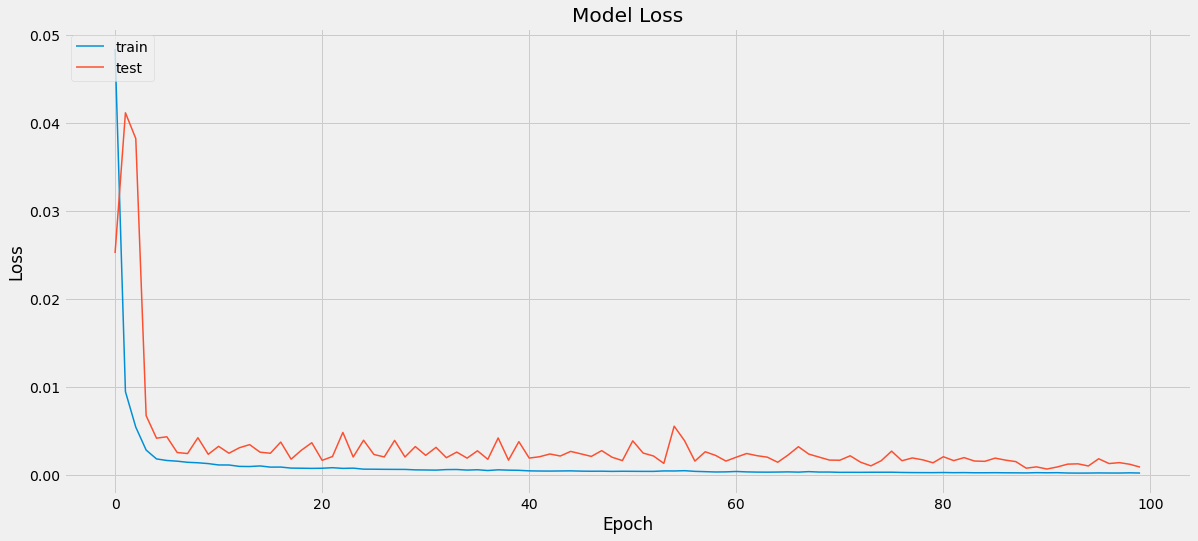

In [26]:
#Plotting loss, it shows that loss has decreased significantly and model trained well
print(history.history.keys())
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'], linewidth=1.5)
plt.plot(history.history['val_loss'], linewidth=1.5)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 4. Evaluation

Evaluate our trained LSTM model with the test set and then apply the root mean square error (RMSE) metric to examine the performance of the model.

## 4.1 Model Accuracy

- Apply the model to predict the stock prices based on the Test set.

- Use the inverse_transform method to denormalize the predicted stock prices to original form.

In [27]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict) #Ouput of train dataset
test_predict=scaler.inverse_transform(test_predict) #Ouput of test dataset

In [29]:
#Transform y train and y test to ori form
y_trainOri=scaler.inverse_transform(y_train.reshape(-1,1))
y_testOri=scaler.inverse_transform(ytest.reshape(-1,1))

#### i - RMSE Performance 

Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result.

In [30]:
# Calculate RMSE performance metrics
training_performance_RMSE=math.sqrt(mean_squared_error(y_trainOri,train_predict)) #Train
testing_performance_RMSE=math.sqrt(mean_squared_error(y_testOri,test_predict)) #Test
print(f'Training Performance for RMSE is >> {training_performance_RMSE:.4f}')
print(f'Testing Performance for RMSE is  >> {testing_performance_RMSE:.4f}')

Training Performance for RMSE is >> 1.1295
Testing Performance for RMSE is  >> 2.3232


#### ii - MAPE Performance 

In [31]:
training_performance_MAPE= np.mean(np.abs((train_predict - y_trainOri)/train_predict))*100
testing_performance_MAPE= np.mean(np.abs((test_predict - y_testOri)/test_predict))*100
print(f'Training Performance for MAPE is >> {training_performance_MAPE:.4f}')
print(f'Testing Performance for MAPE is  >> {testing_performance_MAPE:.4f}')

Training Performance for MAPE is >> 1.7872
Testing Performance for MAPE is  >> 2.3794


## 4.2 Visualizing the Predicted Average Prices

Based on the graph below,it is apparently that the line follow the real stock prices closely. As a result, we can say that the LSTM works very well with time series or sequential data.

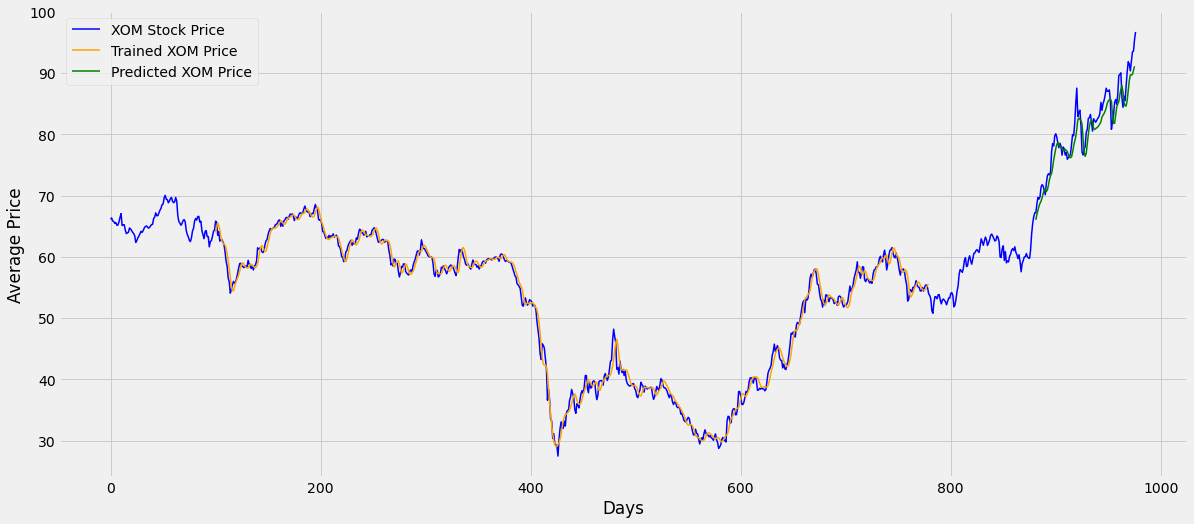

In [32]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(XOM_partial_ds1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(XOM_partial_ds1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(XOM_partial_ds1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.plot(scaler.inverse_transform(XOM_partial_ds1),color = 'blue',label = 'XOM Stock Price',linewidth=1.5)
plt.plot(trainPredictPlot, color = 'orange', label = 'Trained XOM Price',linewidth=1.5 )
plt.plot(testPredictPlot, color = 'green', label = 'Predicted XOM Price',linewidth=1.5 )
plt.legend()
plt.show()

In [33]:
len(test_data) #Based on 100 previous days

196

In [34]:
#Test data from 196-100(Prev 100days),so it starts from 102 day
x_input=test_data[96:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:
#Creating list of last 100 data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
print(len(test_data[96:]))

100


In [37]:
print(len(temp_input))

100


In [38]:
actual=XOM_partial_ds1[training_size+101:len(XOM_partial_ds1),:1]
actual=scaler.inverse_transform(actual)

predict=test_predict

In [39]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(95):
    print(f'{actual[i]}  \t\t {predict[i]} ')

   Actual                    Predicted
------------------------------------------------
[68.58436013]  		 [66.03625] 
[69.68819092]  		 [66.907326] 
[69.42141006]  		 [67.59225] 
[69.82035627]  		 [68.27625] 
[71.41614025]  		 [68.74462] 
[71.7783703]  		 [69.08227] 
[71.56544495]  		 [69.666985] 
[70.87279149]  		 [70.349365] 
[70.13608766]  		 [70.8648] 
[71.99375554]  		 [71.00393] 
[73.20282892]  		 [70.67316] 
[73.56751036]  		 [70.904724] 
[73.38149263]  		 [71.70408] 
[73.82205281]  		 [72.61115] 
[77.11151838]  		 [73.22619] 
[78.47723553]  		 [73.62542] 
[78.10031212]  		 [74.571075] 
[79.71078483]  		 [75.84076] 
[80.0950395]  		 [76.789856] 
[79.53211115]  		 [77.667694] 
[78.5256438]  		 [78.36716] 
[77.81046939]  		 [78.652275] 
[78.54049355]  		 [78.43843] 
[78.06288078]  		 [77.963425] 
[76.59046422]  		 [77.827415] 
[77.92924728]  		 [77.79999] 
[77.64961639]  		 [77.34529] 
[76.6102599]  		 [77.37372] 
[77.01857512]  		 [77.56482] 
[75.92972801]  		 [77.359184] 
[76.18

# 5. Advanced Analysis

#### Predict for the next 30 days price and compare to the actual 30 days price

In [40]:
#Once get the output will append to the list,then we'll taking the last 100 values to cal next value
lst_output=[] #Predict next 30 days output value
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #Shift one position to right and taking new output then putting as input
        x_input=np.array(temp_input[1:]) 
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1)) #reshape
        yhat = model.predict(x_input, verbose=0) #reshape
        print(yhat[0]) #Output
        temp_input.extend(yhat[0].tolist()) #Append to input list
        #print(len(temp_input))
        lst_output.extend(yhat.tolist()) #Add into final output
        i=i+1
    

print(lst_output)

[0.8583543]
1 day input [0.49508067 0.50953658 0.5181209  0.51812089 0.5361829  0.55057509
 0.54709669 0.55229832 0.5731048  0.5778277  0.5750515  0.5660204
 0.55641495 0.58063598 0.59640038 0.60115524 0.59872987 0.60447407
 0.64736346 0.66517024 0.66025576 0.68125376 0.68626383 0.67892414
 0.66580141 0.65647667 0.66599503 0.65976772 0.64056975 0.65802535
 0.65437941 0.64082785 0.64615163 0.6319548  0.63527816 0.63824659
 0.64237656 0.66451078 0.68445081 0.68186954 0.70697217 0.74920773
 0.78340918 0.72281456 0.73236512 0.73636606 0.70313253 0.64728095
 0.6409247  0.65308875 0.65902557 0.68922613 0.695292   0.71894267
 0.72039465 0.72736397 0.71094078 0.69196871 0.71820056 0.71449009
 0.71071495 0.71455459 0.71916849 0.72191112 0.7293967  0.75314406
 0.73594659 0.75030471 0.75743542 0.76863162 0.78315109 0.77673027
 0.77682704 0.77953733 0.75482195 0.69567926 0.71290902 0.72539577
 0.75282146 0.75908092 0.74894964 0.76914782 0.80993138 0.8125127
 0.81590059 0.76311412 0.74243194 0.7662

8 day output [[0.8454225]]
9 day input [0.5731048  0.5778277  0.5750515  0.5660204  0.55641495 0.58063598
 0.59640038 0.60115524 0.59872987 0.60447407 0.64736346 0.66517024
 0.66025576 0.68125376 0.68626383 0.67892414 0.66580141 0.65647667
 0.66599503 0.65976772 0.64056975 0.65802535 0.65437941 0.64082785
 0.64615163 0.6319548  0.63527816 0.63824659 0.64237656 0.66451078
 0.68445081 0.68186954 0.70697217 0.74920773 0.78340918 0.72281456
 0.73236512 0.73636606 0.70313253 0.64728095 0.6409247  0.65308875
 0.65902557 0.68922613 0.695292   0.71894267 0.72039465 0.72736397
 0.71094078 0.69196871 0.71820056 0.71449009 0.71071495 0.71455459
 0.71916849 0.72191112 0.7293967  0.75314406 0.73594659 0.75030471
 0.75743542 0.76863162 0.78315109 0.77673027 0.77682704 0.77953733
 0.75482195 0.69567926 0.71290902 0.72539577 0.75282146 0.75908092
 0.74894964 0.76914782 0.80993138 0.8125127  0.81590059 0.76311412
 0.74243194 0.76621169 0.75683369 0.78776731 0.81827721 0.83956241
 0.83467301 0.82010258 

16 day output [[0.8345817]]
17 day input [0.59872987 0.60447407 0.64736346 0.66517024 0.66025576 0.68125376
 0.68626383 0.67892414 0.66580141 0.65647667 0.66599503 0.65976772
 0.64056975 0.65802535 0.65437941 0.64082785 0.64615163 0.6319548
 0.63527816 0.63824659 0.64237656 0.66451078 0.68445081 0.68186954
 0.70697217 0.74920773 0.78340918 0.72281456 0.73236512 0.73636606
 0.70313253 0.64728095 0.6409247  0.65308875 0.65902557 0.68922613
 0.695292   0.71894267 0.72039465 0.72736397 0.71094078 0.69196871
 0.71820056 0.71449009 0.71071495 0.71455459 0.71916849 0.72191112
 0.7293967  0.75314406 0.73594659 0.75030471 0.75743542 0.76863162
 0.78315109 0.77673027 0.77682704 0.77953733 0.75482195 0.69567926
 0.71290902 0.72539577 0.75282146 0.75908092 0.74894964 0.76914782
 0.80993138 0.8125127  0.81590059 0.76311412 0.74243194 0.76621169
 0.75683369 0.78776731 0.81827721 0.83956241 0.83467301 0.82010258
 0.84076845 0.86061944 0.86211885 0.88672885 0.90299424 0.85835427
 0.85660672 0.85025001

24 day output [[0.81475186]]
25 day input [0.66580141 0.65647667 0.66599503 0.65976772 0.64056975 0.65802535
 0.65437941 0.64082785 0.64615163 0.6319548  0.63527816 0.63824659
 0.64237656 0.66451078 0.68445081 0.68186954 0.70697217 0.74920773
 0.78340918 0.72281456 0.73236512 0.73636606 0.70313253 0.64728095
 0.6409247  0.65308875 0.65902557 0.68922613 0.695292   0.71894267
 0.72039465 0.72736397 0.71094078 0.69196871 0.71820056 0.71449009
 0.71071495 0.71455459 0.71916849 0.72191112 0.7293967  0.75314406
 0.73594659 0.75030471 0.75743542 0.76863162 0.78315109 0.77673027
 0.77682704 0.77953733 0.75482195 0.69567926 0.71290902 0.72539577
 0.75282146 0.75908092 0.74894964 0.76914782 0.80993138 0.8125127
 0.81590059 0.76311412 0.74243194 0.76621169 0.75683369 0.78776731
 0.81827721 0.83956241 0.83467301 0.82010258 0.84076845 0.86061944
 0.86211885 0.88672885 0.90299424 0.85835427 0.85660672 0.85025001
 0.84510744 0.84239995 0.84181321 0.84261954 0.84404349 0.84542251
 0.84628683 0.8463841

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131) #30days need to predict

### 5.1 Visualizing Testing Data

In [42]:
len(XOM_partial_ds1)

977

In [43]:
scaler.inverse_transform(lst_output)

array([[93.29377048],
       [93.15973965],
       [92.6722019 ],
       [92.27778492],
       [92.07013063],
       [92.02512911],
       [92.08697191],
       [92.19618424],
       [92.30194969],
       [92.36824053],
       [92.37570116],
       [92.31988355],
       [92.20754434],
       [92.05190876],
       [91.86833696],
       [91.67095932],
       [91.47049595],
       [91.27353432],
       [91.08261616],
       [90.89722034],
       [90.71471369],
       [90.53170417],
       [90.34480891],
       [90.15134445],
       [89.94961935],
       [89.7326027 ],
       [89.49927505],
       [89.25059642],
       [88.98791539],
       [88.71300111]])

In [44]:
XOM_partial_ds3=XOM_partial_ds1.tolist()
len(XOM_partial_ds3)

977

In [45]:
print(type(XOM_partial_ds3))

<class 'list'>


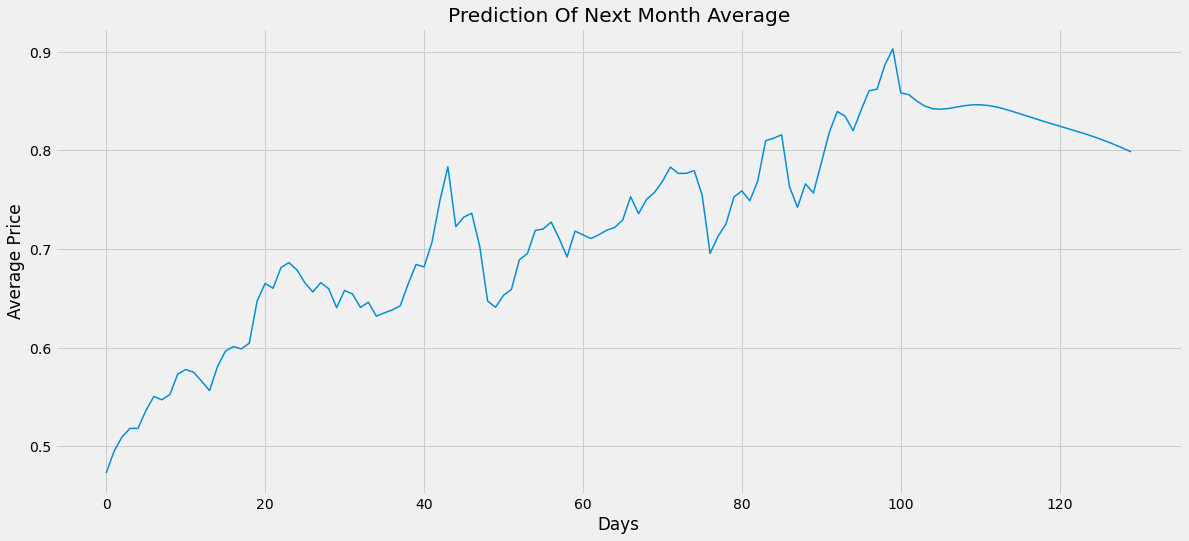

In [46]:
#Fill the upper gap
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.title("Prediction Of Next Month Average")
XOM_partial_ds3.extend(lst_output)
#PLot only 137 days because 1007-907(starting rows)+30days
plt.plot(XOM_partial_ds3[877:],linewidth=1.5)

In [47]:
#Creating final data for plotting
final_graph = scaler.inverse_transform(XOM_partial_ds3).tolist()

In [48]:
XOM_partial_ds_Ori=df.reset_index()['Average'] 

scaler=MinMaxScaler(feature_range=(0,1))
XOM_partial_ds_Ori=scaler.fit_transform(np.array(XOM_partial_ds_Ori).reshape(-1,1)) #Fit to data, then transform it

In [49]:
print(final_graph[len(final_graph)-1])
print(scaler.inverse_transform(XOM_partial_ds_Ori)[-1:])

[88.71300110835693]
[[84.04750061]]


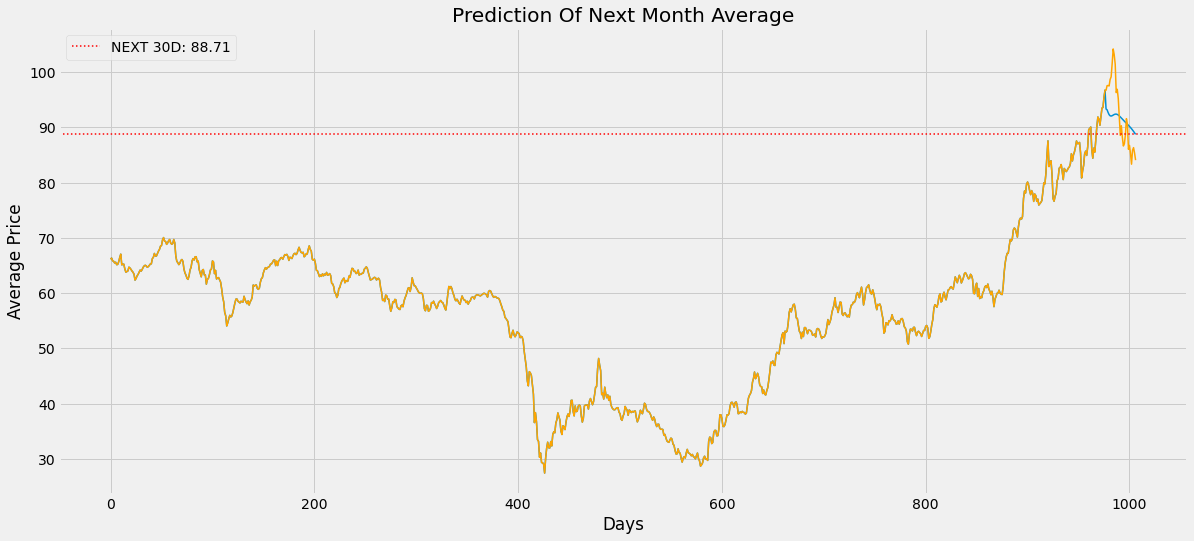

In [50]:
#Plotting final results with predicted value after 30 Days
plt.figure(figsize=(18,8))
plt.plot(final_graph,linewidth=1.5)
plt.plot(scaler.inverse_transform(XOM_partial_ds_Ori),linewidth=1.5,color='orange')
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.title("Prediction Of Next Month Average")
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)),linewidth=1.5)
plt.legend()

#### Average Price Comparison Between Predicted and Actual 30 Days Average Price

In [51]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(30):
    print(f'{XOM_partial_ds1_Future[i]}  \t\t {lst_output[i]} ')

   Actual                    Predicted
------------------------------------------------
[0.90266828]  		 [0.8583542704582214] 
[0.91335977]  		 [0.8566067218780518] 
[0.91381611]  		 [0.8502500057220459] 
[0.91270786]  		 [0.8451074361801147] 
[0.92802801]  		 [0.8423999547958374] 
[0.93428641]  		 [0.8418132066726685] 
[0.96531784]  		 [0.8426195383071899] 
[1.]  		 [0.844043493270874] 
[0.98647267]  		 [0.8454225063323975] 
[0.96385103]  		 [0.8462868332862854] 
[0.89709434]  		 [0.8463841080665588] 
[0.90488481]  		 [0.8456563353538513] 
[0.88294768]  		 [0.8441916108131409] 
[0.83891047]  		 [0.8421623706817627] 
[0.79614451]  		 [0.8397688865661621] 
[0.81902691]  		 [0.8371953964233398] 
[0.79158106]  		 [0.8345816731452942] 
[0.77120855]  		 [0.8320136070251465] 
[0.77648909]  		 [0.8295243382453918] 
[0.7976439]  		 [0.8271070718765259] 
[0.83565087]  		 [0.824727475643158] 
[0.82212354]  		 [0.8223413228988647] 
[0.76341808]  		 [0.8199045062065125] 
[0.77264276]  		 [0.817382

In [52]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(30):
    print(f'{scaler.inverse_transform(XOM_partial_ds1_Future)[i]}  \t\t {scaler.inverse_transform(lst_output)[i]} ')

   Actual                    Predicted
------------------------------------------------
[96.69249916]  		 [93.29377048] 
[97.51249886]  		 [93.15973965] 
[97.5474987]  		 [92.6722019] 
[97.46249962]  		 [92.27778492] 
[98.63750076]  		 [92.07013063] 
[99.1174984]  		 [92.02512911] 
[101.49749947]  		 [92.08697191] 
[104.15749931]  		 [92.19618424] 
[103.12000084]  		 [92.30194969] 
[101.38500023]  		 [92.36824053] 
[96.26499748]  		 [92.37570116] 
[96.86249924]  		 [92.31988355] 
[95.1799984]  		 [92.20754434] 
[91.80249977]  		 [92.05190876] 
[88.52250099]  		 [91.86833696] 
[90.27750015]  		 [91.67095932] 
[88.17250061]  		 [91.47049595] 
[86.61000061]  		 [91.27353432] 
[87.01499939]  		 [91.08261616] 
[88.63749886]  		 [90.89722034] 
[91.55249977]  		 [90.71471369] 
[90.5150013]  		 [90.53170417] 
[86.01249886]  		 [90.34480891] 
[86.71999931]  		 [90.15134445] 
[85.21499825]  		 [89.94961935] 
[83.3200016]  		 [89.7326027] 
[85.84500122]  		 [89.49927505] 
[86.31500053]  		 [89.25

# LSTM Model : JNJ (Partial)

In [73]:
JNJ_partial_ds=pd.read_csv('dataset/JNJ.csv')

### 1.1 Date Extration Within 2018-07-12 - 2022-07-12

In [74]:
mask=(JNJ_partial_ds['Date'] >= '2018-07-12') & (JNJ_partial_ds['Date'] <= '2022-07-12')
JNJ_partial_ds=JNJ_partial_ds.loc[mask]
print(JNJ_partial_ds)

             Date        Open        High         Low       Close    Volume  \
14229  2018-07-12  114.945321  115.395352  114.459293  114.990326   6199000   
14230  2018-07-13  112.794193  114.756301  112.794193  113.343224   8250200   
14231  2018-07-16  113.406212  113.496216  111.750125  112.227150   7314400   
14232  2018-07-17  115.683361  117.492455  114.810311  116.205391  12858700   
14233  2018-07-18  115.935366  116.151383  114.459286  115.026321   7152000   
...           ...         ...         ...         ...         ...       ...   
15231  2022-07-06  178.070007  179.440002  177.410004  178.300003   5335600   
15232  2022-07-07  177.860001  179.119995  177.509995  178.500000   5725800   
15233  2022-07-08  178.330002  179.990005  177.770004  178.279999   3828300   
15234  2022-07-11  177.699997  179.020004  177.520004  178.350006   3645200   
15235  2022-07-12  177.979996  178.449997  175.199997  175.850006   4708800   

       Dividends  Stock Splits  
14229        0.0  

### 1.2 Create Average column

In [75]:
average=(JNJ_partial_ds['Open']+JNJ_partial_ds['High']+JNJ_partial_ds['Low']+JNJ_partial_ds['Close'])/4
y=average.values
JNJ_partial_ds.insert(8, "Average", average, True)

### 1.3 Drop OHLC column

In [76]:
#Drop columns - Date,Volume,Dividends,Stock Splits 
df=JNJ_partial_ds.drop(['Open', 'High', 'Low', 'Close','Dividends','Stock Splits','Volume'], axis=1)
JNJ_partial_ds_Ori=df
JNJ_partial_ds1=df

In [77]:
df

,Date,Average
14229,2018-07-12,114.947573
14230,2018-07-13,113.421978
14231,2018-07-16,112.719926
14232,2018-07-17,116.047880
14233,2018-07-18,115.393089
...,...,...
15231,2022-07-06,178.305004
15232,2022-07-07,178.247498
15233,2022-07-08,178.592503
15234,2022-07-11,178.147503


In [78]:
#Pick up only 'Average' column
JNJ_partial_ds1=df.reset_index()['Average'] 

### 1.4 Dateset Size

In [79]:
JNJ_partial_ds1.shape

(1007,)

# 2. Data Preprocessing

### 2.1 MinMaxScaler

In [80]:
#LSTM are sensitive to the scale of the data , we use MinMaxScaler to scale the data range to 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
JNJ_partial_ds1=scaler.fit_transform(np.array(JNJ_partial_ds1).reshape(-1,1)) #Fit to data, then transform it

#### Exclude 30 days data 

In [81]:
JNJ_partial_ds1_Future=JNJ_partial_ds1[-30:]
JNJ_partial_ds1=JNJ_partial_ds1[:-30] #Exclude 30 days

In [82]:
#df1 have already converted to array and have the values between 0 to 1
JNJ_partial_ds1

array([[0.09711152],
       [0.07714941],
       [0.0679632 ],
       [0.1115088 ],
       [0.102941  ],
       [0.08589361],
       [0.07226187],
       [0.07844471],
       [0.10453078],
       [0.1082701 ],
       [0.12773118],
       [0.13506265],
       [0.14669243],
       [0.15116763],
       [0.15369978],
       [0.14828214],
       [0.14386588],
       [0.14524964],
       [0.14410129],
       [0.13980265],
       [0.13915527],
       [0.13532766],
       [0.12902685],
       [0.12107736],
       [0.12360942],
       [0.14451354],
       [0.16559442],
       [0.19156249],
       [0.19789272],
       [0.18373072],
       [0.18090456],
       [0.18894194],
       [0.19554673],
       [0.18727757],
       [0.18778164],
       [0.19308686],
       [0.18837436],
       [0.18345433],
       [0.1897968 ],
       [0.20793573],
       [0.21587902],
       [0.22397049],
       [0.22992771],
       [0.24335385],
       [0.25067446],
       [0.24966673],
       [0.24945947],
       [0.257

In [83]:
len(JNJ_partial_ds1)

977

### 2.2 Preparation of Training and Testing set

In [84]:
training_size=int(len(JNJ_partial_ds1)*0.8) #Split train into 80%
test_size=len(JNJ_partial_ds1)-training_size 
train_data,test_data=JNJ_partial_ds1[0:training_size,:],JNJ_partial_ds1[training_size:len(JNJ_partial_ds1),:1]

#### Training and Testing size

In [85]:
training_size,test_size

(781, 196)

In [86]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#Converting independent and dependent feature based on time steps
time_step=100 #Predict based on 100 days
X_train,y_train=create_dataset(train_data,time_step)
X_test,ytest=create_dataset(test_data,time_step)

100
(0)
DataX 
----------------
 [0.09711152 0.07714941 0.0679632  0.1115088  0.102941   0.08589361
 0.07226187 0.07844471 0.10453078 0.1082701  0.12773118 0.13506265
 0.14669243 0.15116763 0.15369978 0.14828214 0.14386588 0.14524964
 0.14410129 0.13980265 0.13915527 0.13532766 0.12902685 0.12107736
 0.12360942 0.14451354 0.16559442 0.19156249 0.19789272 0.18373072
 0.18090456 0.18894194 0.19554673 0.18727757 0.18778164 0.19308686
 0.18837436 0.18345433 0.1897968  0.20793573 0.21587902 0.22397049
 0.22992771 0.24335385 0.25067446 0.24966673 0.24945947 0.25719528
 0.25950714 0.26896142 0.28209167 0.26851676 0.24845144 0.23819662
 0.23449187 0.22980869 0.24036015 0.25473524 0.25197902 0.23724824
 0.24602138 0.24270159 0.23908614 0.23878924 0.20328234 0.17844546
 0.18357249 0.20553501 0.22880137 0.24160488 0.23887848 0.23707083
 0.23401732 0.23286165 0.22337755 0.22180653 0.22275503 0.24326476
 0.25882523 0.25968493 0.26558272 0.26744998 0.27648942 0.29931151
 0.31030751 0.31356783 0.3167

DataY 
----------------
 0.18988420782712234

100
(204)
DataX 
----------------
 [0.28799739 0.27814907 0.27628765 0.2583629  0.25385913 0.24334997
 0.23971692 0.23431221 0.24971558 0.24893461 0.25545032 0.25911322
 0.25509016 0.26187559 0.27510818 0.26664359 0.20019697 0.18783266
 0.17797736 0.18432581 0.20497319 0.21966525 0.23707798 0.26440664
 0.26894117 0.28481203 0.30165077 0.29983695 0.29457672 0.28260581
 0.29052617 0.29001164 0.30669964 0.30709229 0.32003121 0.33336279
 0.31712891 0.30415982 0.28484256 0.28154733 0.27982415 0.30443169
 0.299686   0.2914327  0.30485502 0.30304131 0.28983047 0.2462379
 0.22825063 0.1983222  0.19327382 0.18886033 0.18057734 0.15485076
 0.15010462 0.15602973 0.17223349 0.1765867  0.18783243 0.1901602
 0.17725187 0.16597575 0.17462158 0.16969401 0.17084313 0.16101805
 0.17967007 0.18870908 0.18746994 0.20077132 0.18154438 0.16815232
 0.18045629 0.19266947 0.1822098  0.18465807 0.1825725  0.15654385
 0.14614771 0.1799246  0.15373136 0.15583312 0.156


DataY 
----------------
 0.3916356511815269

100
(404)
DataX 
----------------
 [0.41399934 0.42025535 0.40369752 0.38690752 0.37956198 0.33808133
 0.25336015 0.28727957 0.28956358 0.32740273 0.33786511 0.3242851
 0.28237256 0.31459426 0.26011939 0.1701208  0.20777462 0.1574977
 0.22795952 0.22993472 0.20777465 0.11243666 0.         0.04811645
 0.07132609 0.11962789 0.11465874 0.20709551 0.23462634 0.17400965
 0.20873142 0.23783563 0.30067461 0.31101389 0.32894565 0.35517941
 0.31863739 0.39215454 0.39752497 0.42974641 0.46311034 0.46243103
 0.44490052 0.48354202 0.50801696 0.50773948 0.50397372 0.4647459
 0.45230802 0.43280214 0.42749334 0.42391322 0.43845011 0.43388249
 0.42517861 0.42848103 0.43184525 0.42823428 0.40835803 0.3987284
 0.42774033 0.46675218 0.44061074 0.42971543 0.41255571 0.39334501
 0.40018196 0.38768842 0.41702623 0.43094909 0.42299336 0.42594531
 0.43520638 0.41879747 0.43045151 0.41419803 0.42411175 0.42982979
 0.39359328 0.36130378 0.34595164 0.38541998 0.38874

DataX 
----------------
 [0.46236942 0.46523584 0.48202674 0.47289109 0.49336727 0.51841141
 0.51381198 0.51189036 0.49825002 0.48583835 0.48423155 0.50697613
 0.53019295 0.50990592 0.51743476 0.5154187  0.51207948 0.52310505
 0.53665105 0.55174043 0.56720769 0.56270306 0.57268906 0.59032999
 0.6052306  0.61398833 0.6092313  0.59111768 0.58185594 0.61754798
 0.61269645 0.63726796 0.64545873 0.62677771 0.64993188 0.67450334
 0.7453197  0.7205907  0.72263817 0.65308184 0.65935109 0.63900054
 0.61713801 0.62441514 0.66779323 0.67138454 0.68171712 0.69844465
 0.69119921 0.67793701 0.68269369 0.6755741  0.67582635 0.66413931
 0.64256606 0.6392061  0.65438981 0.65844709 0.62440285 0.62614671
 0.61597132 0.58823499 0.54766122 0.55802678 0.5891226  0.59711064
 0.60662007 0.61612971 0.61660525 0.61961662 0.63362733 0.63080609
 0.62849233 0.62712898 0.61368869 0.62376892 0.6354024  0.6455141
 0.66453331 0.68681708 0.68488354 0.68006517 0.65828862 0.66763951
 0.66925632 0.66852702 0.66589612 0.64

#### Training Shape

In [87]:
print(f'x_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

x_train shape : (680, 100)
y_train shape : (680,)


#### Testing Shape

In [88]:
print(f'X_test shape : {X_test.shape}')
print(f'y_test shape : {ytest.shape}')

X_test shape : (95, 100)
y_test shape : (95,)


# 3. Modelling

In [89]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1) #Converted into 3 dimensions
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 3.1 Create the Stacked LSTM mode 

In [90]:
model=Sequential() 
#Set return=true because we have another LSTM layer
model.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(100,1))) 
model.add(LSTM(100,activation='relu',return_sequences=True))
model.add(LSTM(50)) #We do not have another LSTM model so return=False (By default)
model.add(Dense(1)) #Last layer , dense =1 because 1 final output

####  Adopt 'adam' optimizer and set MSE as loss function

In [91]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 151,451
Trainable params: 151,451
Non-trainable params: 0
_________________________________________________________________


# 3.2 Training LSTM Model

In [93]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 6s 234ms/step - loss: 0.0887 - val_loss: 0.0042
Epoch 2/100
11/11 [==============================] - 2s 145ms/step - loss: 0.0159 - val_loss: 0.0500
Epoch 3/100
11/11 [==============================] - 2s 145ms/step - loss: 0.0100 - val_loss: 0.0240
Epoch 4/100
11/11 [==============================] - 2s 146ms/step - loss: 0.0064 - val_loss: 0.0044
Epoch 5/100
11/11 [==============================] - 2s 148ms/step - loss: 0.0042 - val_loss: 0.0092
Epoch 6/100
11/11 [==============================] - 2s 149ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 7/100
11/11 [==============================] - 2s 147ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 8/100
11/11 [==============================] - 2s 147ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 9/100
11/11 [==============================] - 2s 145ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 10/100
11/11 [==============================] - 2s 147ms/step - loss: 0.0032 - val_lo

Epoch 80/100
11/11 [==============================] - 2s 194ms/step - loss: 7.1060e-04 - val_loss: 7.1316e-04
Epoch 81/100
11/11 [==============================] - 2s 193ms/step - loss: 5.9601e-04 - val_loss: 0.0016
Epoch 82/100
11/11 [==============================] - 2s 215ms/step - loss: 6.6271e-04 - val_loss: 5.1923e-04
Epoch 83/100
11/11 [==============================] - 2s 195ms/step - loss: 5.2908e-04 - val_loss: 0.0022
Epoch 84/100
11/11 [==============================] - 2s 206ms/step - loss: 9.6190e-04 - val_loss: 0.0012
Epoch 85/100
11/11 [==============================] - 2s 203ms/step - loss: 7.7352e-04 - val_loss: 9.8693e-04
Epoch 86/100
11/11 [==============================] - 2s 189ms/step - loss: 6.8452e-04 - val_loss: 7.3174e-04
Epoch 87/100
11/11 [==============================] - 2s 190ms/step - loss: 6.1160e-04 - val_loss: 5.4473e-04
Epoch 88/100
11/11 [==============================] - 2s 193ms/step - loss: 5.9700e-04 - val_loss: 6.2484e-04
Epoch 89/100
11/11 [==

dict_keys(['loss', 'val_loss'])


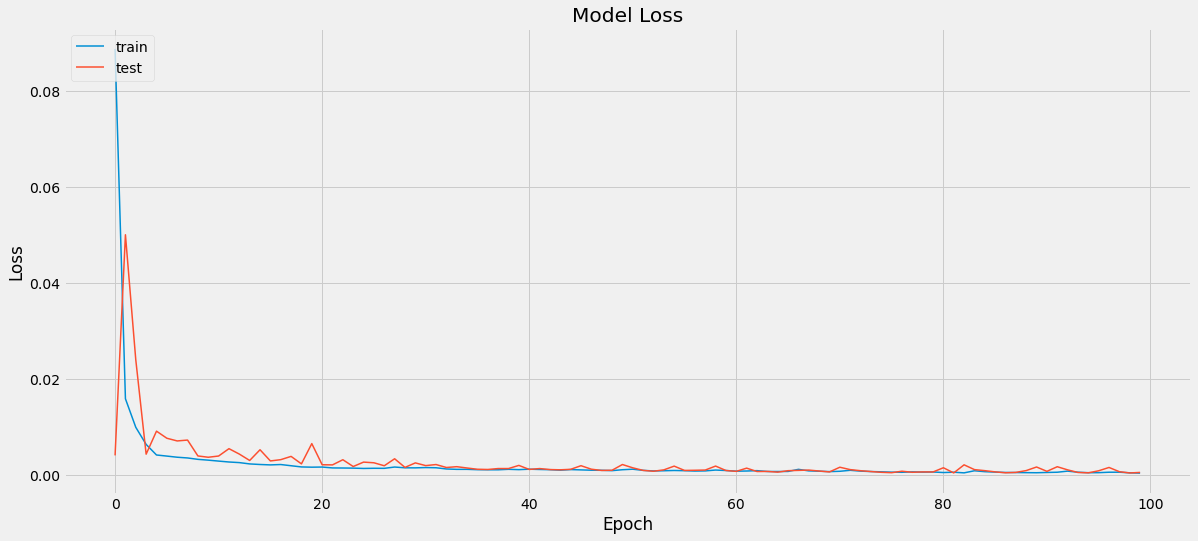

In [94]:
#Plotting loss, it shows that loss has decreased significantly and model trained well
print(history.history.keys())
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'], linewidth=1.5)
plt.plot(history.history['val_loss'], linewidth=1.5)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 4. Evaluation

# 4.1 Model Accuracy

In [95]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [96]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict) #Ouput of train dataset
test_predict=scaler.inverse_transform(test_predict) #Ouput of test dataset

In [97]:
#Transform y train and y test to ori form
y_trainOri=scaler.inverse_transform(y_train.reshape(-1,1))
y_testOri=scaler.inverse_transform(ytest.reshape(-1,1))

#### i - RMSE Performance

In [98]:
training_performance_RMSE=math.sqrt(mean_squared_error(y_trainOri,train_predict)) #Train
testing_performance_RMSE=math.sqrt(mean_squared_error(y_testOri,test_predict)) #Test
print(f'Training Performance for RMSE is >> {training_performance_RMSE:.4f}')
print(f'Testing Performance for RMSE is  >> {testing_performance_RMSE:.4f}')

Training Performance for RMSE is >> 1.6375
Testing Performance for RMSE is  >> 1.8993


#### ii - MAPE Performance

In [119]:
training_performance_MAPE= np.mean(np.abs((train_predict - y_trainOri)/train_predict))*100
testing_performance_MAPE= np.mean(np.abs((test_predict - y_testOri)/test_predict))*100
print(f'Training Performance for MAPE is >> {training_performance_MAPE:.4f}')
print(f'Testing Performance for MAPE is  >> {testing_performance_MAPE:.4f}')

Training Performance for MAPE is >> 0.8517
Testing Performance for MAPE is  >> 0.8849


# 4.2 Visualizing the Predicted Average Prices

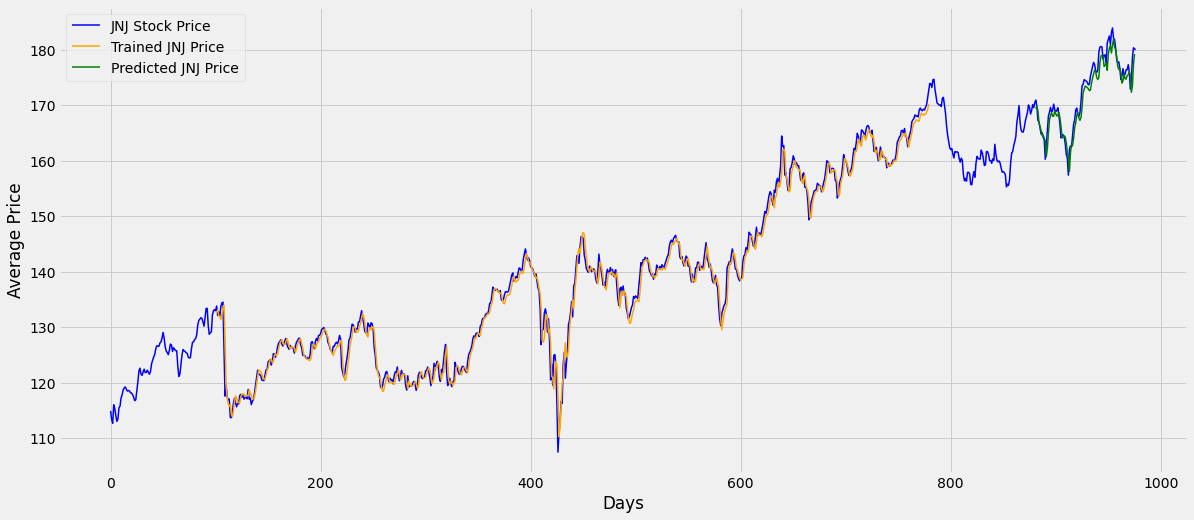

In [118]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(JNJ_partial_ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(JNJ_partial_ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(JNJ_partial_ds)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.plot(scaler.inverse_transform(JNJ_partial_ds),color = 'blue',label = 'JNJ Stock Price',linewidth=1.5)
plt.plot(trainPredictPlot, color = 'orange', label = 'Trained JNJ Price',linewidth=1.5 )
plt.plot(testPredictPlot, color = 'green', label = 'Predicted JNJ Price',linewidth=1.5 )
plt.legend()
plt.show()

In [100]:
#Test data from 196-100(Prev 100days),so it starts from 102 day
x_input=test_data[96:].reshape(1,-1)
x_input.shape

(1, 100)

In [101]:
#Creating list of last 100 data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [102]:
actual=JNJ_partial_ds1[training_size+101:len(JNJ_partial_ds1),:1]
actual=scaler.inverse_transform(actual)

predict=test_predict

In [103]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(95):
    print(f'{actual[i]}  \t\t {predict[i]} ')

   Actual                    Predicted
------------------------------------------------
[169.74757557]  		 [169.40805] 
[167.29911898]  		 [169.89162] 
[167.00787712]  		 [169.02214] 
[165.92927269]  		 [166.87439] 
[164.85808139]  		 [166.23451] 
[165.07775713]  		 [165.44641] 
[164.21635351]  		 [164.55382] 
[163.76961724]  		 [164.6418] 
[160.28452212]  		 [164.07005] 
[162.89586645]  		 [163.60025] 
[165.70714049]  		 [160.75737] 
[168.05685669]  		 [162.25906] 
[168.77262429]  		 [165.00601] 
[169.62169711]  		 [167.35266] 
[168.83186642]  		 [168.16115] 
[169.08608767]  		 [168.7118] 
[170.22639822]  		 [168.05542] 
[169.25146371]  		 [168.03055] 
[168.87876383]  		 [168.97949] 
[169.08609423]  		 [168.48306] 
[169.57727504]  		 [168.07529] 
[168.12103954]  		 [168.22507] 
[166.48462581]  		 [168.72617] 
[164.15712035]  		 [167.71785] 
[164.76429012]  		 [166.19908] 
[164.69025691]  		 [164.11147] 
[164.32495458]  		 [164.32736] 
[163.11184685]  		 [164.52176] 
[161.18672231]  		

# 5. Advanced Analysis

In [104]:
#Once get the output will append to the list,then we'll taking the last 100 values to cal next value
lst_output=[] #Predict next 30 days output value
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #Shift one position to right and taking new output then putting as input
        x_input=np.array(temp_input[1:]) 
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1)) #reshape
        yhat = model.predict(x_input, verbose=0) #reshape
        print(yhat[0]) #Output
        temp_input.extend(yhat[0].tolist()) #Append to input list
        #print(len(temp_input))
        lst_output.extend(yhat.tolist()) #Add into final output
        i=i+1
    

print(lst_output)

[0.9309739]
1 day input [0.81922876 0.81202682 0.82416995 0.82995107 0.81415839 0.78212083
 0.77830999 0.76419667 0.75018035 0.75305477 0.74178347 0.73593802
 0.69033626 0.72450517 0.76129012 0.79203568 0.80140135 0.81251129
 0.80217652 0.80550295 0.82042369 0.80766687 0.80279016 0.80550304
 0.81193004 0.7928755  0.77146336 0.74100842 0.74895311 0.7479844
 0.7432045  0.72733123 0.70214137 0.69346308 0.65299674 0.71449264
 0.72200078 0.71940062 0.74514301 0.77348574 0.78320429 0.80647641
 0.8110269  0.79510035 0.79171995 0.79987838 0.82549079 0.8635195
 0.86660731 0.87817843 0.87639072 0.87466796 0.87187277 0.86566458
 0.86777728 0.88623903 0.89755026 0.90908875 0.9188722  0.91380181
 0.8983953  0.8954701  0.90083305 0.94250192 0.95475563 0.95625073
 0.95485311 0.92712791 0.93535126 0.93661882 0.91545949 0.96476672
 0.97341255 0.98111577 0.96102875 0.98898155 1.         0.97520028
 0.97269749 0.95183043 0.92530795 0.91831966 0.92026986 0.90453832
 0.87824321 0.88753925 0.90401822 0.8887

10 day output [[0.8497604]]
11 day input [0.74178347 0.73593802 0.69033626 0.72450517 0.76129012 0.79203568
 0.80140135 0.81251129 0.80217652 0.80550295 0.82042369 0.80766687
 0.80279016 0.80550304 0.81193004 0.7928755  0.77146336 0.74100842
 0.74895311 0.7479844  0.7432045  0.72733123 0.70214137 0.69346308
 0.65299674 0.71449264 0.72200078 0.71940062 0.74514301 0.77348574
 0.78320429 0.80647641 0.8110269  0.79510035 0.79171995 0.79987838
 0.82549079 0.8635195  0.86660731 0.87817843 0.87639072 0.87466796
 0.87187277 0.86566458 0.86777728 0.88623903 0.89755026 0.90908875
 0.9188722  0.91380181 0.8983953  0.8954701  0.90083305 0.94250192
 0.95475563 0.95625073 0.95485311 0.92712791 0.93535126 0.93661882
 0.91545949 0.96476672 0.97341255 0.98111577 0.96102875 0.98898155
 1.         0.97520028 0.97269749 0.95183043 0.92530795 0.91831966
 0.92026986 0.90453832 0.87824321 0.88753925 0.90401822 0.88870944
 0.8910171  0.90154817 0.90151562 0.91321665 0.89712771 0.85575114
 0.87814581 0.9300887

21 day output [[0.8206218]]
22 day input [0.80766687 0.80279016 0.80550304 0.81193004 0.7928755  0.77146336
 0.74100842 0.74895311 0.7479844  0.7432045  0.72733123 0.70214137
 0.69346308 0.65299674 0.71449264 0.72200078 0.71940062 0.74514301
 0.77348574 0.78320429 0.80647641 0.8110269  0.79510035 0.79171995
 0.79987838 0.82549079 0.8635195  0.86660731 0.87817843 0.87639072
 0.87466796 0.87187277 0.86566458 0.86777728 0.88623903 0.89755026
 0.90908875 0.9188722  0.91380181 0.8983953  0.8954701  0.90083305
 0.94250192 0.95475563 0.95625073 0.95485311 0.92712791 0.93535126
 0.93661882 0.91545949 0.96476672 0.97341255 0.98111577 0.96102875
 0.98898155 1.         0.97520028 0.97269749 0.95183043 0.92530795
 0.91831966 0.92026986 0.90453832 0.87824321 0.88753925 0.90401822
 0.88870944 0.8910171  0.90154817 0.90151562 0.91321665 0.89712771
 0.85575114 0.87814581 0.93008872 0.95318338 0.95079537 0.94850559
 0.93097389 0.91495085 0.90027571 0.8881284  0.87865758 0.87144852
 0.86586815 0.8612974

In [105]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131) #30days need to predict

# 5.1 Visualizing Testing Data

In [106]:
JNJ_partial_ds3=JNJ_partial_ds1.tolist()
len(JNJ_partial_ds3)

977

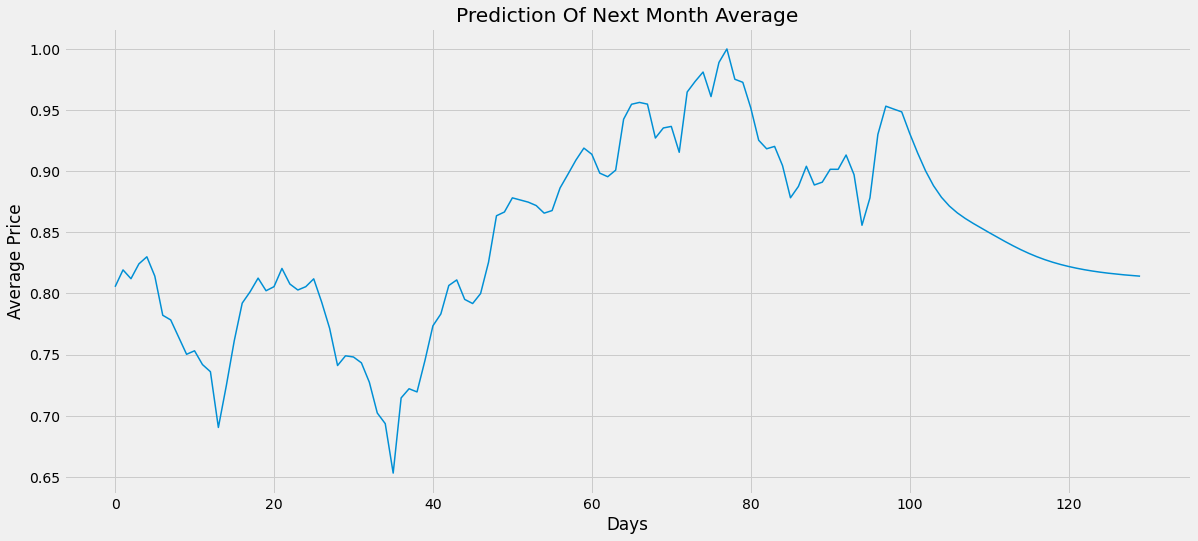

In [107]:
#Fill the upper gap
plt.figure(figsize=(18,8))
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.title("Prediction Of Next Month Average")
JNJ_partial_ds3.extend(lst_output)
#PLot only 137 days because 1007-907(starting rows)+30days
plt.plot(JNJ_partial_ds3[877:],linewidth=1.5)

In [108]:
#Creating final data for plotting
final_graph = scaler.inverse_transform(JNJ_partial_ds3).tolist()

In [112]:
JNJ_partial_ds_Ori=df.reset_index()['Average'] 

scaler=MinMaxScaler(feature_range=(0,1))
JNJ_partial_ds_Ori=scaler.fit_transform(np.array(JNJ_partial_ds_Ori).reshape(-1,1)) #Fit to data, then transform it

In [113]:
print(final_graph[len(final_graph)-1])
print(scaler.inverse_transform(JNJ_partial_ds_Ori)[-1:])

[169.74325655216117]
[[176.86999893]]


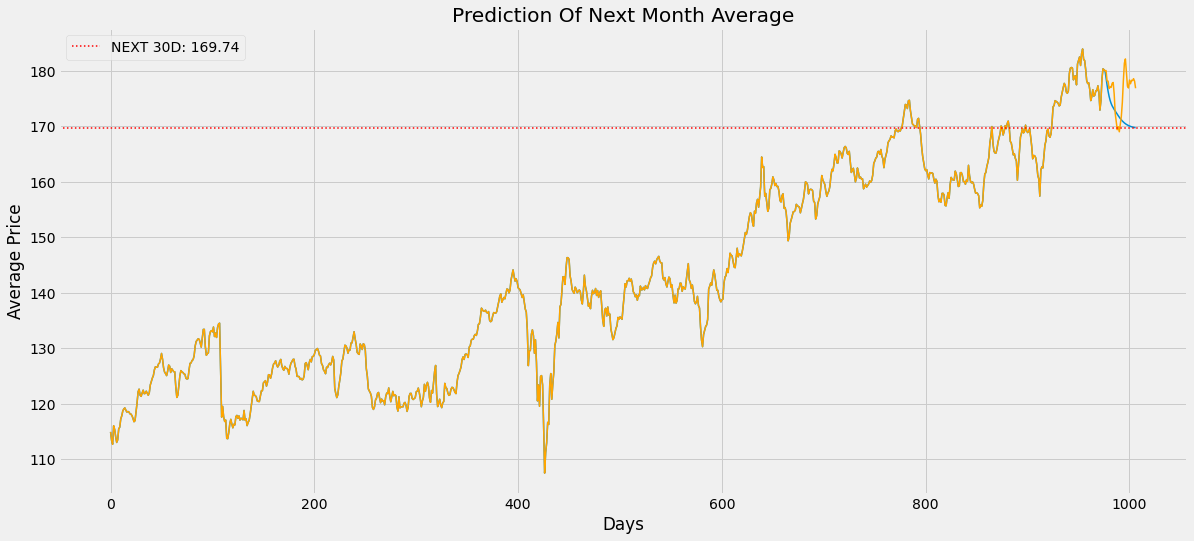

In [115]:
#Plotting final results with predicted value after 30 Days
plt.figure(figsize=(18,8))
plt.plot(final_graph,linewidth=1.5)
plt.plot(scaler.inverse_transform(JNJ_partial_ds_Ori),linewidth=1.5,color='orange')
plt.ylabel("Average Price")
plt.xlabel("Days")
plt.title("Prediction Of Next Month Average")
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)),linewidth=1.5)
plt.legend()

#### Average Price Comparison Between Predicted and Actual 30 Days Average Price 

In [116]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(30):
    print(f'{JNJ_partial_ds1_Future[i]}  \t\t {lst_output[i]} ')

   Actual                    Predicted
------------------------------------------------
[0.94909433]  		 [0.9309738874435425] 
[0.9244622]  		 [0.9149508476257324] 
[0.92406968]  		 [0.900275707244873] 
[0.90673231]  		 [0.888128399848938] 
[0.91006895]  		 [0.8786575794219971] 
[0.90941472]  		 [0.8714485168457031] 
[0.91893387]  		 [0.8658681511878967] 
[0.92092935]  		 [0.8612974286079407] 
[0.89338586]  		 [0.8572682738304138] 
[0.84791617]  		 [0.85347580909729] 
[0.82799458]  		 [0.8497604131698608] 
[0.80967584]  		 [0.8460834622383118] 
[0.81651268]  		 [0.8424772024154663] 
[0.80470365]  		 [0.839009702205658] 
[0.82246629]  		 [0.8357526063919067] 
[0.8409485]  		 [0.8327553868293762] 
[0.87421663]  		 [0.8300462961196899] 
[0.92541093]  		 [0.8276340961456299] 
[0.96656252]  		 [0.8255116939544678] 
[0.9764743]  		 [0.8236556053161621] 
[0.94304264]  		 [0.82203608751297] 
[0.91212982]  		 [0.8206217885017395] 
[0.90804077]  		 [0.8193803429603577] 
[0.92665395]  		 [0.81829

In [117]:
print('   Actual                    Predicted')
print('------------------------------------------------')
for i in range(30):
    print(f'{scaler.inverse_transform(JNJ_partial_ds1_Future)[i]}  \t\t {scaler.inverse_transform(lst_output)[i]} ')

   Actual                    Predicted
------------------------------------------------
[180.05999756]  		 [178.67515045] 
[178.17749786]  		 [177.45059644] 
[178.14749908]  		 [176.32905507] 
[176.82249832]  		 [175.40070227] 
[177.07749939]  		 [174.67689884] 
[177.02750015]  		 [174.1259493] 
[177.75499725]  		 [173.69947222] 
[177.90750122]  		 [173.35015669] 
[175.80250168]  		 [173.04223025] 
[172.32749939]  		 [172.75239275] 
[170.80500031]  		 [172.46844519] 
[169.40499878]  		 [172.18743578] 
[169.92750168]  		 [171.9118289] 
[169.02500153]  		 [171.64682667] 
[170.38250351]  		 [171.39790451] 
[171.79499817]  		 [171.16884328] 
[174.33750153]  		 [170.96180217] 
[178.25000381]  		 [170.77745082] 
[181.39499664]  		 [170.61524713] 
[182.15250015]  		 [170.47339634] 
[179.59749985]  		 [170.34962538] 
[177.23500061]  		 [170.24153818] 
[176.9224968]  		 [170.14666124] 
[178.34500122]  		 [170.06389217] 
[177.67750168]  		 [169.99197828] 
[178.30500412]  		 [169.92947101] 
[178.